# SHAP Values

Values were computed with the python files in `pcmasking.offline_evaluation`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printe
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
# Relative imports
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from pathlib import Path
import pickle
import datetime
import time
import glob
import re
import numpy as np

In [5]:
from pcmasking.utils.setup import SetupDiagnostics
from pcmasking.neural_networks.load_models import load_models, get_save_plot_folder, load_single_model
from pcmasking.utils.pcmci_aggregation import get_matrix_idx, get_matrix_insets_idx, get_matrix_2d_idx
from pcmasking.neural_networks.model_diagnostics import ModelDiagnostics
from pcmasking.utils.variable import Variable_Lev_Metadata
from pcmasking.utils.constants import SPCAM_Vars
from pcmasking.utils.plotting import plot_matrix_insets

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.transforms as mtransforms
import matplotlib.gridspec as gridspec

In [7]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [8]:
font_size = 13

In [9]:
plt.rcParams["font.size"] = font_size
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Computer Modern"] + plt.rcParams["font.serif"]
plt.rcParams["mathtext.default"] = "regular"

## Setup

In [10]:
PROJECT_ROOT = Path.cwd().parent.resolve()

# PCMasking
base_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001") 
train_val = "train"

cfg = os.path.join(base_dir, f"cfg_mask_net_thresholds_{train_val}.yml")
shap_dict_dir = Path(base_dir, "plots_offline_evaluation", f"shap_{train_val}", "range-all_samples-1000_all")
num_inputs_file = os.path.join(base_dir, "threshold_performance", f"num_inputs_per_var_{train_val}.p")
outputs_map_file = Path(base_dir, "outputs_map.txt")

# Vanilla NN
single_base_dir = os.path.join(PROJECT_ROOT, "output", "training_94_single_nn") 
single_cfg = os.path.join(single_base_dir, "cfg_single_nn.yml")
single_shap_dict_dir = Path(single_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")

# Causally-informed NN
causal_base_dir = os.path.join(PROJECT_ROOT, "output", "eval_nando", "causal_single_nn", 
                              "models_arch-rasp_thrs-opt-mse6") 
causal_cfg = os.path.join(causal_base_dir, "cfg_causal_single_nn_diagnostics.yml")
causal_shap_dict_dir = Path(causal_base_dir, "plots_offline_evaluation", "shap", "range-all_samples-1000_all")

In [11]:
def get_setup(config):
    argv  = ["-c", config]
    
    return SetupDiagnostics(argv)

In [12]:
setup = get_setup(cfg)
single_setup = get_setup(single_cfg)
causal_setup = get_setup(causal_cfg)

## Load SHAP Dictionaries

In [13]:
def parse_txt_to_dict(txt_file):
    line_dict = dict()
    with open(txt_file, 'r') as f:
        for line in f:
            value, key = line.split(":")
            line_dict[key.lstrip().rstrip("\n")] = value.lstrip().rstrip()
    return line_dict

In [14]:
def load_shap_dict(shap_dir, outputs_map):
    outputs_varname2save = parse_txt_to_dict(outputs_map)
    outputs_save2varname = {value: key for key, value in outputs_varname2save.items()}
    
    shap_dict_per_var = {}
    for file in glob.glob(str(shap_dir) + "/*.p"):
        with open(file, "rb") as f:
            d = pickle.load(f)
        var_save_key = re.findall(r"[0-9]_[0-9]+",Path(file).name)[0]
        shap_dict_per_var[Variable_Lev_Metadata.parse_var_name(outputs_save2varname[var_save_key])] = d
    return shap_dict_per_var



## Calculate SHAP Matrix

In [15]:
def generate_output_vars(setup):
    output_list = list()
    # Use setup.output_order here instead of setup.spcam_outputs to get the right order of variables
    for spcam_var in setup.spcam_outputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.children_idx_levs:
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                # For CausalSingleNN, there are no networks for variables phq-3.64 and phq-7.59
                if setup.nn_type == "CausalSingleNN" and (var_name == "phq-3.64" or var_name == "phq-7.59"):
                    continue
                output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            output_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return output_list

In [16]:
def generate_input_vars(setup):
    inputs_list = list()
    for spcam_var in setup.spcam_inputs:
        if spcam_var.dimensions == 3:
            for level, _ in setup.parents_idx_levs:
                # There's enough info to build a Variable_Lev_Metadata list
                # However, it could be better to do a bigger reorganization
                var_name = f"{spcam_var.name}-{round(level, 2)}"
                inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
        elif spcam_var.dimensions == 2:
            var_name = spcam_var.name
            inputs_list.append(Variable_Lev_Metadata.parse_var_name(var_name))
    return sorted([p for p in inputs_list], key=lambda x: setup.input_order_list.index(x),)
    

In [17]:
def calculate_shap_matrix(setup, shap_dict_per_var, metric):
    output_vars = {i: var for i, var in enumerate(generate_output_vars(single_setup))}
    input_vars = generate_input_vars(setup)
    
    num_inputs = len(input_vars)
    
    input_inverse_idx = list(range(num_inputs-1, -1, -1))
    input_inverse_idx2var = {i: input_vars[num_inputs - 1 - i] for i in range(num_inputs)}
    
    
    metric_key = "shap_values_" + metric
    shap_matrix = np.ma.zeros([len(output_vars), len(input_vars)])

    
    for i, var in output_vars.items():
        if setup.nn_type == "CausalSingleNN" and (str(var) == "phq-3.64" or str(var) == "phq-7.59"):
            # No causal drivers were found for these variables
            continue
            
        var_inputs_idx = {input: idx for idx, input in enumerate(shap_dict_per_var[var]["inputs"])}
        for k in range(num_inputs):
            j = input_inverse_idx[k]
            # Check if this input is an input for the current variables
            try: 
                shap_matrix[i, k] = shap_dict_per_var[var][metric_key][var_inputs_idx[j]]
            except KeyError: 
                # This means the input was not part of the variables network inputs
                pass
            
    return shap_matrix, input_inverse_idx2var, output_vars


## Plot Functions

In [18]:
def plot_matrix( pc_alpha, matrix, in_vars, in_box_idx, in_ticks, in_ticks_labs, 
                out_vars, out_box_idx, out_ticks, out_ticks_labs, extend, 
                cbar_label, title=None, num_parents=False, only_3d=False, 
                **kwargs):
    vars_labs_dict = {
        'tbp': 'T (hPa)',
        'qbp': 'q (hPa)',
        'vbp': 'V (hPa)',
        'tphystnd': r'$\Delta$T$\mathregular{_{phy}}$ (hPa)',
        'phq': '$\Delta$q$\mathregular{_{phy}}$ (hPa)',
    }

    fig, axes = plt.subplots(1, 1, figsize=(12, 5))
    
    I = axes.imshow(matrix, **kwargs)

    axes.tick_params(bottom=True, left=True, length=4)
    axes.tick_params(axis='x', labelsize=11)
    axes.tick_params(axis='y', labelsize=11)
    
    axes.set_xticks(in_ticks);
    axes.set_xticklabels(in_ticks_labs)
    axes.set_yticks(out_ticks);
    axes.set_yticklabels(out_ticks_labs)
    
    if only_3d:
        labels = axes.get_yticklabels()
        # offset bottom label 
        offset = mtransforms.ScaledTranslation(0, +0.04, fig.dpi_scale_trans)
        labels[-1].set_transform(labels[-1].get_transform() + offset)
        
    
    if not only_3d: 
        axes.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        axes.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')
    else: 
        axes.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        axes.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')

    axes.set_xlim(xmax=len(matrix[0]) - .5)
    axes.set_ylim(ymin=len(matrix) - .5)

    trans = axes.get_xaxis_transform()
    if not only_3d:
        # Annotate y-axis (outputs)
        xy_coor = [(-13., .68), (-13., .20)]
        for i, iVar in enumerate(out_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)
        axes.annotate('out-2Ds', xy=(-20.1, .005), xycoords=trans, rotation=0, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(12., -.13), (42., -.13), (72., -.13)]
        for i, iVar in enumerate(in_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)
        axes.annotate('in-2Ds', xy=(.6, -.25), xycoords=trans, rotation=90, fontsize=font_size)

    else: 
        # Annotate y-axis (outputs)
        xy_coor = [(-13., .65), (-13., .17)]
        for i, iVar in enumerate(out_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(10., -.112), (40., -.112), (70., -.112)]
        for i, iVar in enumerate(in_vars):
            axes.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)

    if isinstance(num_parents, dict):
        divider = make_axes_locatable(axes)
        axy = divider.append_axes("right", size="20%", pad=.15, sharey=axes)

        colors = {"CI-NN": "firebrick", "PCMasking": "royalblue"}
        for key, values in num_parents.items():

            axy.plot(
                values,
                range(len(values)),
                color=colors[key],
                alpha=.8,
                linewidth=3.,
                label=key,
            )

        axy.set_xticks([0, 50, 100])
        
        axy.xaxis.set_tick_params(labelright=False, labelsize=11)
        axy.yaxis.set_tick_params(labelleft=False)
        
        axy.set_xlabel('Num. Inputs', fontsize=font_size)
        
        axy.get_yaxis().set_visible(False)
        axy.spines['top'].set_visible(False)
        axy.spines['right'].set_visible(False)
        axy.spines['bottom'].set_visible(True)
        axy.set_xlim(-1., 100.)
        
        axy.legend(prop={'size': 11}, loc="center right", bbox_to_anchor=(2.5, -0.1), fancybox=True)#bbox_to_anchor=(1.15, -0.15))

        #  (left, bottom, width, height)
        cax = fig.add_axes([axy.get_position().x1 - 0.06, axy.get_position().y0, 
                            0.01, axes.get_position().height])
        cbar = plt.colorbar(I, cax=cax, extend=extend) # Similar to fig.colorbar(im, cax = cax)
        cbar.set_label(cbar_label, fontsize=font_size)
        cbar.ax.tick_params(labelsize=11)
    
    else: 
        #  (left, bottom, width, height)
        cax = fig.add_axes([axes.get_position().x1 +0.01 , axes.get_position().y0, 
                            0.01, axes.get_position().height])
        cbar = plt.colorbar(I, cax=cax, extend=extend) # Similar to fig.colorbar(im, cax = cax)
        cbar.set_label(cbar_label, fontsize=font_size)
    
    axes.set_title(title, fontsize=14)
    return fig, axes

In [19]:
def plot_matrix_shap(clima_case, nn_case, metric, input_dict_inv_remap_var,  dict_outputs_idxs, 
                     shap_matrix, title=None, diff=False, save=False, savenm=False, cmap=False, 
                     extend=False, interpolation='none', insets=False, num_parents=False, 
                     only_3d=False, **kwargs):

    if only_3d: 
        input_dict_inv_remap_var = {key: value for key, value in input_dict_inv_remap_var.items() if value.var.name in ['vbp', 'tbp', 'qbp']}
        dict_outputs_idxs = {key: value for key, value in dict_outputs_idxs.items() if value.var.name in ['tphystnd', 'phq']}

        shap_matrix = shap_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_dict_inv_remap_var.keys())]

        if num_parents:
            for k in num_parents.keys():
                num_parents[k] =  num_parents[k][list(dict_outputs_idxs.keys())]
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=insets)
    # this is a hack, it works for now
    out_ticks -= 0.5


    # Plotting
    if diff is False and 'abs' in metric and 'sign' not in metric:
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        vmax=maximum; vmin=-1*maximum
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP Values'
    
    if insets:
        out_vars_2d, out_vars_2d_ticks = get_matrix_2d_idx(dict_outputs_idxs)
        fig, ax = plot_matrix_insets(None, shap_matrix, 
                                     in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                     out_vars, out_box_idx,out_ticks, out_ticks_labs,
                                     out_vars_2d, out_vars_2d_ticks, 
                                     extend, cbar_label, 
                                     dict_outputs_idxs=dict_outputs_idxs,
                                     mask=False,num_parents=False, 
                                     cmap=cmap,
                                     norm=norm,
                                     interpolation=interpolation, 
                                    )
    else:
        fig, ax = plot_matrix(None, shap_matrix,
                              in_vars, in_box_idx, in_ticks, in_ticks_labs,
                              out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                              extend, cbar_label, num_parents=num_parents,
                              cmap=cmap,
                              norm=norm,
                              title=title,
                              interpolation=interpolation, 
                              only_3d=only_3d,
                              )
    ax.set_rasterized(True)
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True)
        if not num_parents:
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}' if not savenm else savenm
        else: 
            f_name = f'SHAP_values_{nn_case}_{clima_case}_{metric}_num_inputs' if not savenm else savenm
        fig.savefig(f"{save}/{f_name}.pdf", format="pdf", transparent=True, bbox_inches="tight")
        fig.savefig(f"{save}/{f_name}.svg", format="svg", transparent=True, bbox_inches="tight")
        fig.savefig(f"{save}/{f_name}.png", dpi=600.,bbox_inches='tight')

        print(f"Saved Shapley matrix {save}/{f_name}")
    return fig, ax

## Plot Single SHAP Matrix

In [20]:
output_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001", 
                          "plots_offline_evaluation", "shap_plots_paper")

In [21]:
only_3d = True

### PCMasking NN

In [22]:
if only_3d:
    name = "pcmasking_only_3d"
else: 
    name = "pcmasking"
title = "PCMasking Framework"


In [23]:
shap_dict_per_var = load_shap_dict(shap_dict_dir, outputs_map_file)
len(shap_dict_per_var.keys())

65

In [24]:
metric = "abs_mean"
shap_matrix, input_inverse_idx2var, output_vars = calculate_shap_matrix(setup, shap_dict_per_var, metric)


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper/SHAP_values_pcmasking_only_3d_0K_abs_mean


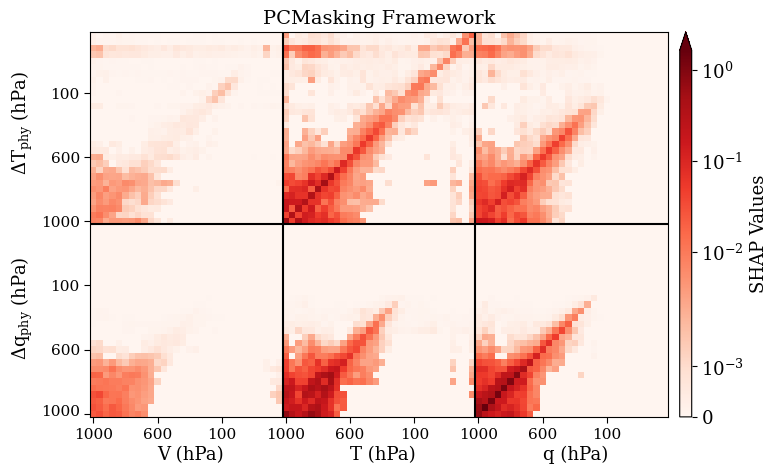

In [25]:
fig, ax = plot_matrix_shap("0K", name, metric, input_inverse_idx2var, 
                           output_vars, shap_matrix, title=title, only_3d=only_3d,
                           save=output_dir)

### Causally-informed NN

In [26]:
if only_3d:
    name = "causal_nn_only_3d"
else: 
    name = "causal_nn"
title = "Causally-informed NN"


In [27]:
causal_shap_dict_per_var = load_shap_dict(causal_shap_dict_dir, outputs_map_file)
len(causal_shap_dict_per_var.keys())

63

In [28]:
metric = "abs_mean"
causal_shap_matrix, causal_input_inverse_idx2var, causal_output_vars = calculate_shap_matrix(causal_setup, causal_shap_dict_per_var, metric)




Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper/SHAP_values_causal_nn_only_3d_0K_abs_mean


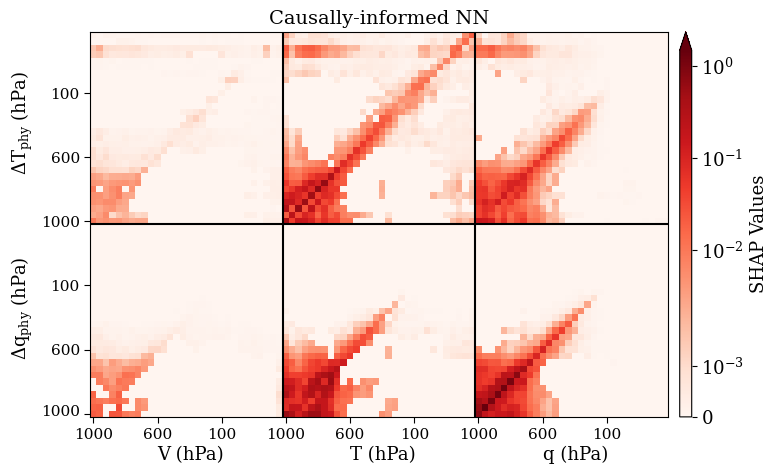

In [29]:
fig, ax = plot_matrix_shap("0K", name, metric, causal_input_inverse_idx2var, 
                           causal_output_vars, causal_shap_matrix, title=title, only_3d=only_3d,
                           save=output_dir)

### Single NN

In [30]:
if only_3d:
    name = "single_nn_only_3d"
else: 
    name = "single_nn"
title = "Standard NN"


In [31]:
single_shap_dict_per_var = load_shap_dict(single_shap_dict_dir, outputs_map_file)
len(single_shap_dict_per_var.keys())

65

In [32]:
metric = "abs_mean"
single_shap_matrix, single_input_inverse_idx2var, single_output_vars = calculate_shap_matrix(single_setup, single_shap_dict_per_var, metric)


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper/SHAP_values_single_nn_only_3d_0K_abs_mean


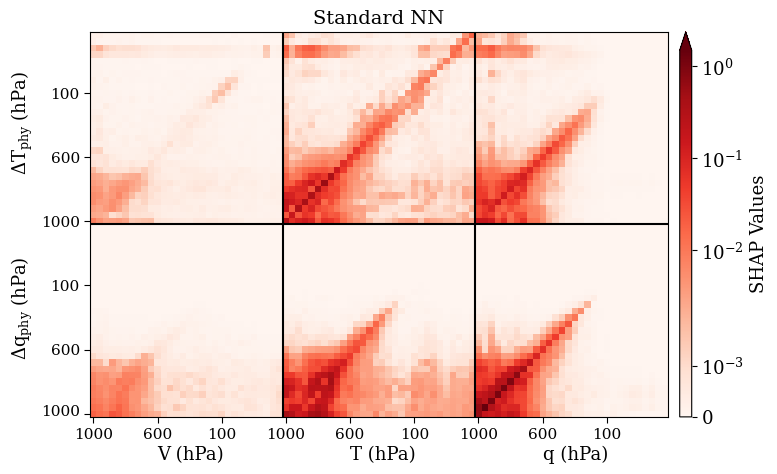

In [33]:
fig, ax = plot_matrix_shap("0K", name, metric, single_input_inverse_idx2var, 
                           single_output_vars, single_shap_matrix, title=title, only_3d=only_3d,
                           save=output_dir)

## Plot with Number of Inputs

In [34]:
causal_num_inputs_file = os.path.join(causal_base_dir,  "num_inputs_per_var.p")
with open(causal_num_inputs_file, "rb") as read_file:
    causal_num_inputs_per_var = pickle.load(read_file)

print(f"Loading num inputs file {num_inputs_file}")
with open(num_inputs_file, "rb") as read_file:
    num_inputs_per_var = pickle.load(read_file)


Loading num inputs file /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/threshold_performance/num_inputs_per_var_train.p


In [35]:
num_inputs = {"CI-NN": np.array(list(causal_num_inputs_per_var.values())), 
              "PCMasking": np.array(list(num_inputs_per_var.values()))}

In [36]:
print(output_dir)

/p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper


In [37]:
if only_3d:
    name = "pcmasking_only_3d"
else: 
    name = "pcmasking"
title = "PCMasking Framework"


Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper/SHAP_values_pcmasking_only_3d_0K_abs_mean_num_inputs


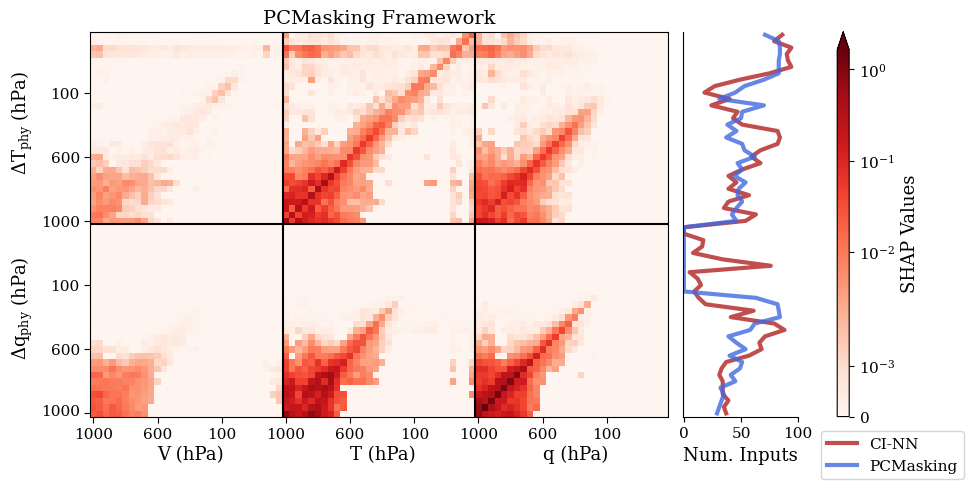

In [38]:
fig, ax = plot_matrix_shap("0K", name, metric, input_inverse_idx2var, output_vars, 
                           shap_matrix, num_parents=num_inputs, 
                           title=title, only_3d=only_3d,  
                           save=output_dir)



## All Three SHAP Plots

In [39]:
def plot_matrix_three_shap(metric, input_dict_inv_remap_var, dict_outputs_idxs, 
                           shap_matrix, causal_shap_matrix, single_shap_matrix, save=False, cmap=False, 
                           extend=False, interpolation='none', num_parents=False, 
                           only_3d=False, **kwargs):

    if only_3d: 
        input_dict_inv_remap_var = {key: value for key, value in input_dict_inv_remap_var.items() if value.var.name in ['vbp', 'tbp', 'qbp']}
        dict_outputs_idxs = {key: value for key, value in dict_outputs_idxs.items() if value.var.name in ['tphystnd', 'phq']}

        shap_matrix = shap_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_dict_inv_remap_var.keys())]
        causal_shap_matrix = causal_shap_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_dict_inv_remap_var.keys())]
        single_shap_matrix = single_shap_matrix[list(dict_outputs_idxs.keys()), :][:, list(input_dict_inv_remap_var.keys())]

        if num_parents:
            for k in num_parents.keys():
                num_parents[k] =  num_parents[k][list(dict_outputs_idxs.keys())]
    
    # Miscellaneous for plotting
    in_vars, in_box_idx, in_ticks, in_ticks_labs = get_matrix_insets_idx(input_dict_inv_remap_var, inverted=True)
    out_vars, out_box_idx, out_ticks, out_ticks_labs = get_matrix_insets_idx(dict_outputs_idxs, insets=False)
    # this is a hack, it works for now
    out_ticks -= 0.5


    # Plotting
    if 'abs' in metric and 'sign' not in metric:
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=0., vmax=shap_matrix.max(), base=10)
        if not cmap: cmap='Reds'
        if not extend: extend='max'
    
    else:
        maximum = max(abs(shap_matrix.max()), abs(shap_matrix.min()))
        vmax=maximum; vmin=-1*maximum
        norm = colors.SymLogNorm(linthresh=0.002, linscale=1.,vmin=vmin, vmax=vmax, base=10)
        if not cmap: cmap='RdBu_r'
        if not extend: extend='both'
        
    cbar_label='SHAP Values'
    
    fig, axes = plot_matrix_three(shap_matrix, causal_shap_matrix, single_shap_matrix,
                                  in_vars, in_box_idx, in_ticks, in_ticks_labs,
                                  out_vars, out_box_idx, out_ticks,  out_ticks_labs,
                                  extend, cbar_label, num_parents=num_parents,
                                  cmap=cmap,
                                  norm=norm,
                                  interpolation=interpolation, 
                                  only_3d=only_3d,
                                 )
    
    for ax in axes:
        ax.set_rasterized(True)

    return fig, axes

In [40]:
def plot_matrix_three(matrix, causal_matrix, single_matrix, in_vars, in_box_idx, in_ticks, in_ticks_labs, 
                out_vars, out_box_idx, out_ticks, out_ticks_labs, extend, 
                cbar_label, num_parents=False, only_3d=False, 
                **kwargs):
    vars_labs_dict = {
        'tbp': 'T (hPa)',
        'qbp': 'q (hPa)',
        'vbp': 'V (hPa)',
        'tphystnd': r'$\Delta$T$\mathregular{_{phy}}$ (hPa)',
        'phq': '$\Delta$q$\mathregular{_{phy}}$ (hPa)',
    }


    fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True, width_ratios=[1, 1, 1.24])

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    
    # Plot standard (single) NN
    im1 = ax1.imshow(single_matrix, **kwargs)

    ax1.tick_params(bottom=True, left=True, length=4)
    ax1.tick_params(axis='x', labelsize=11)
    ax1.tick_params(axis='y', labelsize=11)
    
    ax1.set_xticks(in_ticks);
    ax1.set_xticklabels(in_ticks_labs)
    ax1.set_yticks(out_ticks);
    ax1.set_yticklabels(out_ticks_labs)
    
    if only_3d:
        ax1.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        ax1.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')
        
    else: 
        ax1.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        ax1.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')        

    ax1.set_xlim(xmax=len(matrix[0]) - .5)
    ax1.set_ylim(ymin=len(matrix) - .5)

    trans = ax1.get_xaxis_transform()
    if not only_3d:
        # Annotate y-axis (outputs)
        xy_coor = [(-12., .68), (-12., .20)]
        for i, iVar in enumerate(out_vars):
            ax1.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)
        ax1.annotate('out-2Ds', xy=(-20.1, .005), xycoords=trans, rotation=0, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(12., -.13), (42., -.13), (72., -.13)]
        for i, iVar in enumerate(in_vars):
            ax1.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords='axes fraction', rotation=0, fontsize=font_size)
        ax1.annotate('in-2Ds', xy=(.6, -.25), xycoords='axes fraction', rotation=90, fontsize=font_size)

    else: 
        # Annotate y-axis (outputs)
        xy_coor = [(-14., .60), (-14., .10)]
        for i, iVar in enumerate(out_vars):
            ax1.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=90, fontsize=font_size)

        # Annotate x-axis (inputs)
        xy_coor = [(10., -.14), (40., -.14), (70., -.14)]
        for i, iVar in enumerate(in_vars):
            ax1.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)

    ax1.set_title("Standard NN", fontsize=14)

    # Plot Causal NN    
    im2 = ax2.imshow(causal_matrix, **kwargs)

    ax2.tick_params(bottom=True, left=True, length=4)
    ax2.tick_params(axis='x', labelsize=11)
    
    ax2.set_xticks(in_ticks);
    ax2.set_xticklabels(in_ticks_labs)

    
    if only_3d:
        ax2.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        ax2.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')
        
    else: 
        ax2.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        ax2.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')        

    ax2.set_xlim(xmax=len(causal_matrix[0]) - .5)
    ax2.set_ylim(ymin=len(causal_matrix) - .5)

    trans = ax2.get_xaxis_transform()
    if not only_3d:
        # Annotate x-axis (inputs)
        xy_coor = [(12., -.13), (42., -.13), (72., -.13)]
        for i, iVar in enumerate(in_vars):
            ax2.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)
        ax2.annotate('in-2Ds', xy=(.6, -.25), xycoords=trans, rotation=90, fontsize=font_size)

    else: 
        # Annotate x-axis (inputs)
        xy_coor = [(10., -.14), (40., -.14), (70., -.14)]
        for i, iVar in enumerate(in_vars):
            ax2.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)

    ax2.set_title("Causally-informed NN", fontsize=14)


    # Plot PCMasking
    im3 = ax3.imshow(matrix, **kwargs)

    ax3.tick_params(bottom=True, left=True, length=4)
    ax3.tick_params(axis='x', labelsize=11)
    
    ax3.set_xticks(in_ticks);
    ax3.set_xticklabels(in_ticks_labs)

    
    if only_3d:
        ax3.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        ax3.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')
        
    else: 
        ax3.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        ax3.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')        

    ax3.set_xlim(xmax=len(causal_matrix[0]) - .5)
    ax3.set_ylim(ymin=len(causal_matrix) - .5)

    trans = ax3.get_xaxis_transform()
    if not only_3d:
        # Annotate x-axis (inputs)
        xy_coor = [(12., -.13), (42., -.13), (72., -.13)]
        for i, iVar in enumerate(in_vars):
            ax3.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)
        ax3.annotate('in-2Ds', xy=(.6, -.25), xycoords=trans, rotation=90, fontsize=font_size)

    else: 
        # Annotate x-axis (inputs)
        xy_coor = [(10., -.14), (40., -.14), (70., -.14)]
        for i, iVar in enumerate(in_vars):
            ax3.annotate(vars_labs_dict[iVar], xy=xy_coor[i], xycoords=trans, rotation=0, fontsize=font_size)

    ax3.set_title("PCMasking Framework", fontsize=14)
    

    if isinstance(num_parents, dict):
        divider = make_axes_locatable(ax3)
        ax4 = divider.append_axes("right", size="20%", pad=.15, sharey=ax3)

        colors = {"CI-NN": "firebrick", "PCMasking": "royalblue"}
        for key, values in num_parents.items():

            ax4.plot(
                values,
                range(len(values)),
                color=colors[key],
                alpha=.8,
                linewidth=3.,
                label=key,
            )

        ax4.set_xticks([0, 50, 100])
        ax4.xaxis.set_tick_params(labelsize=11)
        ax4.yaxis.set_visible(False)
        ax4.set_yticks(out_ticks)
                              
        ax4.set_title('Num. Inputs', fontsize=font_size)
        
        ax4.spines['top'].set_visible(False)
        ax4.spines['right'].set_visible(False)
        ax4.set_xlim(-1., 100.)

        if only_3d:
            ax4.hlines(out_box_idx[:-1], xmin=-.5, xmax=100, color='k')
        else: 
            ax4.hlines(out_box_idx, xmin=-.5, xmax=100, color='k')        
            #font size 12, bbox_to_anchor=(1.8, -0.15)
    
        ax4.legend(prop={'size': 11}, loc="center right", bbox_to_anchor=(1.5, -0.2), fancybox=True)#bbox_to_anchor=(1.15, -0.15))
        
        # (left, bottom, width, height)
        cax = fig.add_axes([ax4.get_position().x1 + 0.011, ax4.get_position().y0, 
                            0.005, ax4.get_position().height])
        cbar = plt.colorbar(im3, cax=cax, extend=None) # Similar to fig.colorbar(im, cax = cax)
        cbar.set_label(cbar_label, fontsize=font_size)
        cbar.ax.tick_params(labelsize=11)
    
    else: 
        #  (left, bottom, width, height)
        cax = fig.add_axes([ax3.get_position().x1 + 0.01 , ax3.get_position().y0, 
                            0.01, ax3.get_position().height])
        cbar = plt.colorbar(im3, cax=cax, extend=None) # Similar to fig.colorbar(im, cax = cax)
        cbar.set_label(cbar_label, fontsize=font_size)


    # labels are not showing up so let's do them again
    ax1.set_xticks(in_ticks);
    ax1.set_xticklabels(in_ticks_labs)
    ax1.set_yticks(out_ticks);
    ax1.set_yticklabels(out_ticks_labs)
    
    if only_3d:
        ax1.vlines(in_box_idx[1:], ymin=-.5, ymax=len(matrix), color='k')
        ax1.hlines(out_box_idx[:-1], xmin=-.5, xmax=len(matrix[0]), color='k')
        
    else: 
        ax1.vlines(in_box_idx, ymin=-.5, ymax=len(matrix), color='k')
        ax1.hlines(out_box_idx, xmin=-.5, xmax=len(matrix[0]), color='k')        
    return fig, axes

In [41]:
only_3d = True

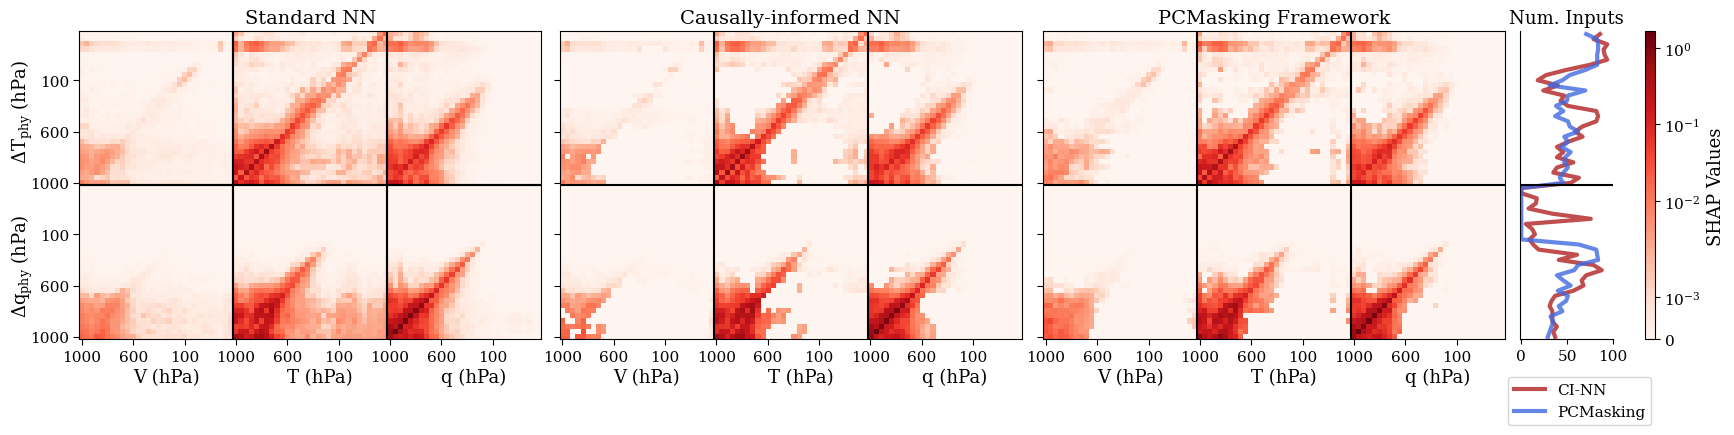

In [42]:
fig, axes = plot_matrix_three_shap(metric, input_inverse_idx2var, output_vars, 
                                   shap_matrix, causal_shap_matrix, single_shap_matrix, 
                                   num_parents=num_inputs, only_3d=only_3d)
# Add some space between the subplots
fig.subplots_adjust(wspace=0.01)

In [43]:

Path(output_dir).mkdir(parents=True, exist_ok=True)
if not num_inputs:
    f_name = f'SHAP_values_all_three_{metric}_only_3d' 
else: 
    f_name = f'SHAP_values_all_three_{metric}_only_3d_num_inputs'
    
fig.savefig(f"{output_dir}/{f_name}.pdf", format="pdf", transparent=True, bbox_inches="tight")
fig.savefig(f"{output_dir}/{f_name}.svg", format="svg", transparent=True, bbox_inches="tight")
fig.savefig(f"{output_dir}/{f_name}.png", dpi=600.,bbox_inches='tight')

print(f"Saved Shapley matrix {output_dir}/{f_name}")

Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/shap_plots_paper/SHAP_values_all_three_abs_mean_only_3d_num_inputs


## Tuning Results

In [44]:
tuning_dirs = ["training_88_mask_net_prediction_thresholds_spars1.0", 
        "training_89_mask_net_prediction_thresholds_spars0.1",
        "training_90_mask_net_prediction_thresholds_spars0.01",
        "training_91_mask_net_prediction_thresholds_spars0.001",
        "training_92_mask_net_prediction_thresholds_spars1e-4",
        "training_93_mask_net_prediction_thresholds_spars1e-5", 
]
train_val = "train"


In [45]:
titles = [r"$\lambda_{spars} = 1.0$", 
          r"$\lambda_{spars} = 0.1$", 
          r"$\lambda_{spars} = 0.01$", 
          r"$\lambda_{spars} = 0.001$", 
          r"$\lambda_{spars} = 10^{-4}$", 
          r"$\lambda_{spars} = 10^{-5}$"
         ]

In [46]:
def get_shap_dicts():

    output_dir = os.path.join(PROJECT_ROOT, "output", "training_91_mask_net_prediction_thresholds_spars0.001", 
                              "plots_offline_evaluation", 
                              f"plots_paper_{train_val}_tuning")
    
    for d, t in zip(tuning_dirs, titles): 
        bd = os.path.join(PROJECT_ROOT, "output", d)
        
        cfg = os.path.join(bd, f"cfg_mask_net_thresholds_{train_val}.yml")
        setup = get_setup(cfg)
        
        shap_dict_dir = Path(bd, "plots_offline_evaluation", f"shap_{train_val}", "range-all_samples-1000_all")
        outputs_map_file = Path(bd, "outputs_map.txt")

        shap_dict_per_var = load_shap_dict(shap_dict_dir, outputs_map_file)

        metric = "abs_mean"
        shap_matrix, input_inverse_idx2var, output_vars = calculate_shap_matrix(setup, shap_dict_per_var, metric)

        name = f"mask_net_{d.split('_')[-1]}"
        fig, ax = plot_matrix_shap("0K", name, metric, input_inverse_idx2var, output_vars, 
                                   shap_matrix, title=t, save=output_dir)



Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/SHAP_values_mask_net_spars1.0_0K_abs_mean
Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/SHAP_values_mask_net_spars0.1_0K_abs_mean
Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/SHAP_values_mask_net_spars0.01_0K_abs_mean
Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/SHAP_values_mask_net_spars0.001_0K_abs_mean
Saved Shapley matrix /p/scratch/icon-a-ml/kuehbacher1/output/training_91_mask_net_prediction_thresholds_spars0.001/plots_offline_evaluation/plots_paper_train_tuning/SHAP

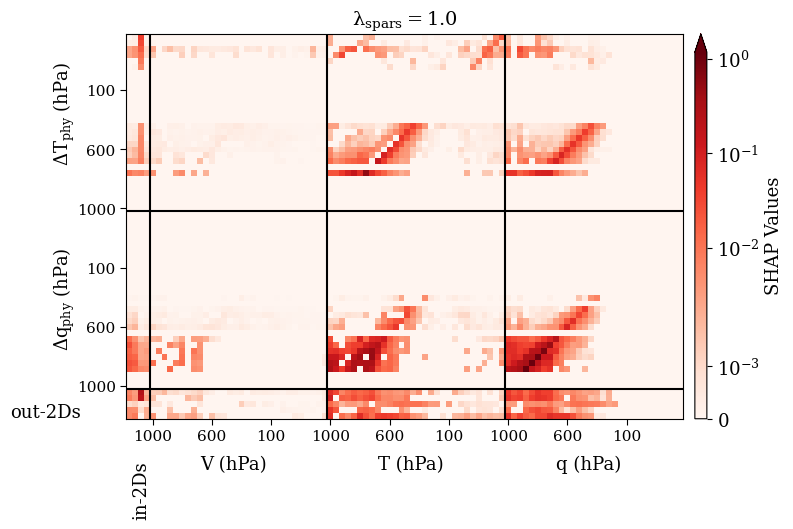

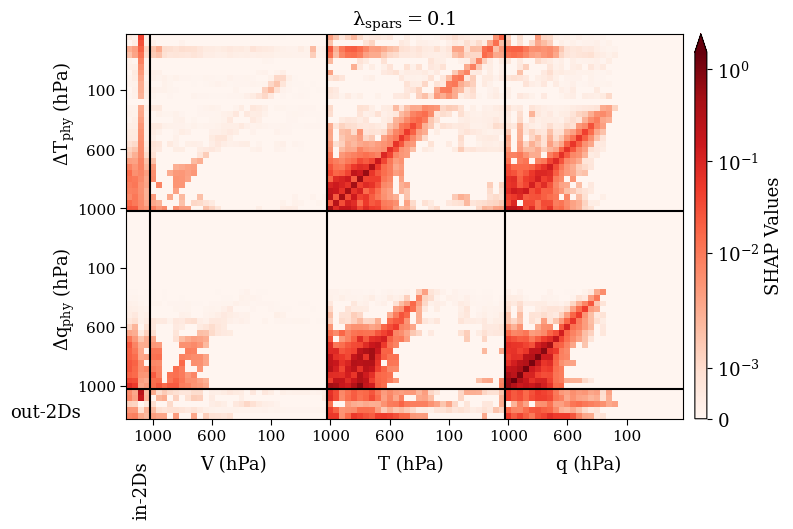

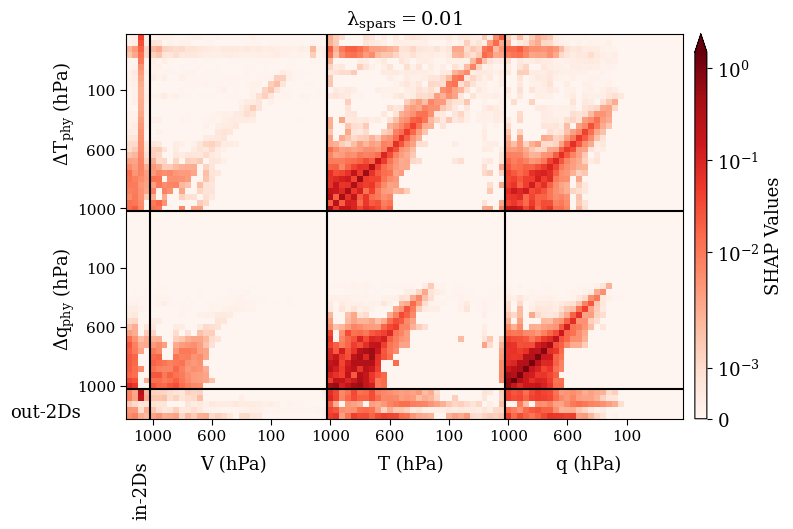

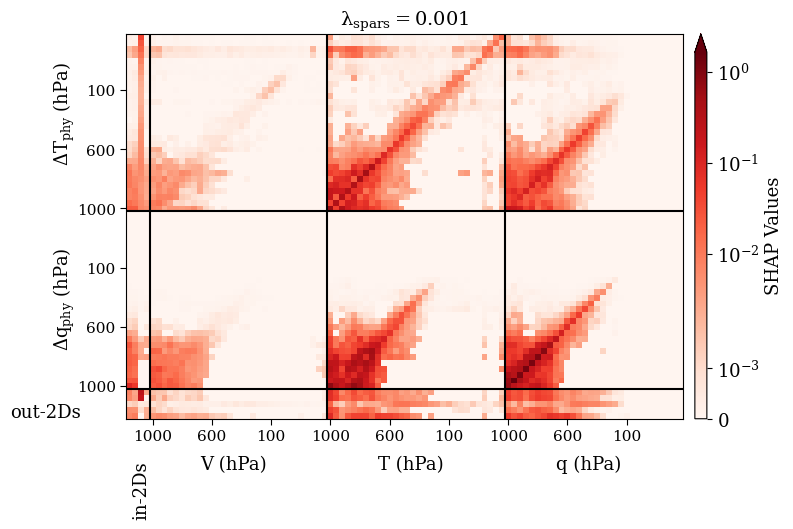

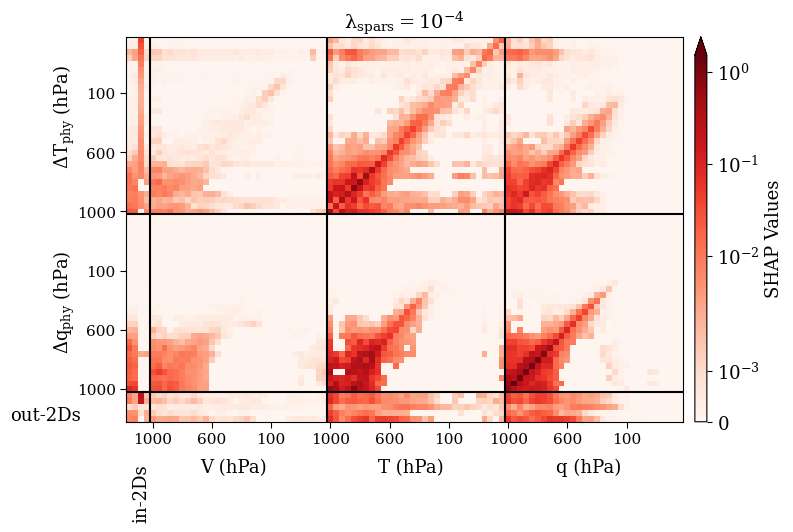

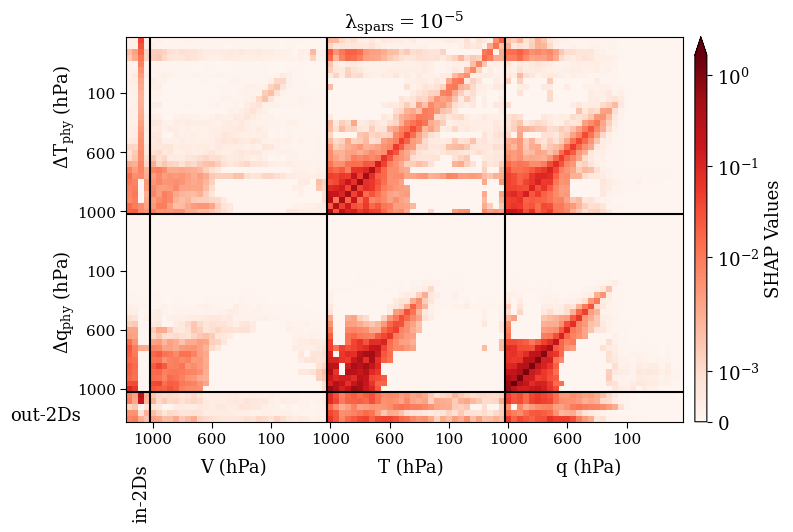

In [47]:
get_shap_dicts()